In [1]:
from threeML import *

import matplotlib.pyplot as plt

%matplotlib inline


WARNING CppInterfaceNotAvailable: The cthreeML package is not installed. You will not be able to use plugins which require the C/C++ interface (currently HAWC)


WARNING NaimaNotAvailable: The naima package is not available. Models that depend on it will not be available


WARNING GSLNotAvailable: The GSL library or the pygsl wrapper cannot be loaded. Models that depend on it will not be available.



Loading xspec models...


WARNING RuntimeWarning: The current value of the parameter switch was above the new maximum 1.0.


WARNING RuntimeWarning: The current value of the parameter redshift was below the new minimum 1.0.


WARNING RuntimeWarning: The current value of the parameter specfile was above the new maximum 1.0.



done
Configuration read from /home/giacomov/.threeML/threeML_config.yml
Loading BKGE...
Success!



WARNING CannotImportPlugin: Could not import plugin /home/giacomov/software/miniconda2/lib/python2.7/site-packages/threeML-0.2.0-py2.7.egg/threeML/plugins/HAWCLike.py. Do you have the relative instrument software installed and configured?



In [2]:
triggerName = 'bn090217206'
ra = 204.9
dec = -8.4

#Data are in the current directory

datadir = os.path.abspath('.')

#Create an instance of the GBM plugin for each detector
#Data files
obsSpectrum = os.path.join( datadir, "bn090217206_n6_srcspectra.pha{1}" )
bakSpectrum = os.path.join( datadir, "bn090217206_n6_bkgspectra.bak{1}" )
rspFile     = os.path.join( datadir, "bn090217206_n6_weightedrsp.rsp{1}" )

#Plugin instance
NaI6 = FermiGBMLike( "NaI6", obsSpectrum, bakSpectrum, rspFile )

#Choose energies to use (in this case, I exclude the energy
#range from 30 to 40 keV to avoid the k-edge, as well as anything above
#950 keV, where the calibration is uncertain)
NaI6.set_active_measurements( "10.0-30.0", "40.0-950.0" )


Now using 117 channels out of 128


In [3]:
#This declares which data we want to use. In our case, all that we have already created.

data_list = DataList( NaI6 )

In [4]:
powerlaw = Powerlaw()

In [5]:
GRB = PointSource( triggerName, ra, dec, spectral_shape=powerlaw )

In [6]:
model = Model( GRB )

In [7]:
jl = JointLikelihood( model, data_list, verbose=False )

res = jl.fit()

Best fit values:



#,Name,Best fit value,Unit
0,bn090217206.spectrum.main.Powerlaw.K,2.56 +/- 0.19,1 / (cm2 keV s)
1,bn090217206.spectrum.main.Powerlaw.index,-1.185 +/- 0.013,



NOTE: errors on parameters are approximate. Use get_errors().

Nuisance parameters:



Name,Value,Unit
InterCalib_of_NaI6,1,



Correlation matrix:



1.00,-0.97
-0.97,1.00



Values of -log(likelihood) at the minimum:



,instrument,-log(likelihood)
0,all,867.817696
1,NaI6,867.817696


In [8]:
res = jl.get_errors()

Name,Value,Unit
bn090217206.spectrum.main.Powerlaw.K,2.56 -0.19 +0.22,1 / (cm2 keV s)
bn090217206.spectrum.main.Powerlaw.index,-1.185 -0.015 +0.015,


 [*********************100%***********************]  completed in 0.1 s

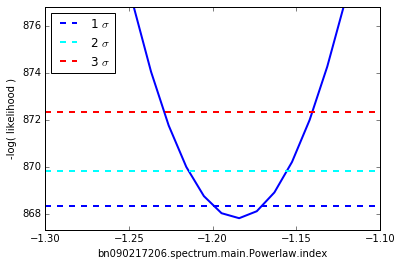

In [9]:
res = jl.get_contours(powerlaw.index,-1.3,-1.1,20)

 [*********************100%***********************]  completed in 4.7 s

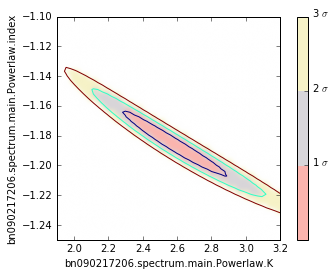

In [10]:
res = jl.get_contours(powerlaw.index,-1.25,-1.1,50,powerlaw.K,1.9,3.2,50)

In [13]:
powerlaw.index.prior = Uniform_prior(lower_bound=-5.0, upper_bound=5.0)
powerlaw.K.prior = Log_uniform_prior(lower_bound=1.0, upper_bound=10)

bayes = BayesianAnalysis(model, data_list)

In [14]:
samples = bayes.sample(n_walkers=50,burn_in=100, n_samples=1000)

#Running burn-in of 100 samples...

# [*********************100%***********************]  100 of 100 completed in 2.4 s

#Sampling...

# [*********************100%***********************]  1000 of 1000 completed in 22.6 s
#Mean acceptance fraction: 0.71655

Running burn-in of 100 samples...

 [*********************100%***********************]  completed in 5.1 s

Sampling...

 [**********************99%***********************]  992 / 1000 in 46.3 s (0:00:00 remaining)
Mean acceptance fraction: 0.71166


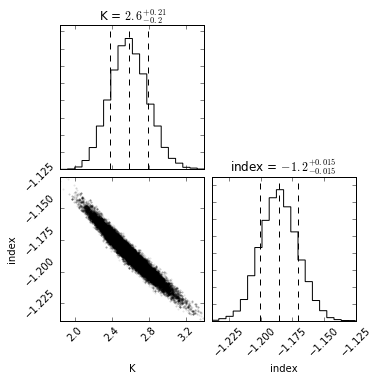

In [15]:
fig = bayes.corner_plot(plot_contours=False, plot_density=False)